In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
df_cleaned = pd.read_csv('cleaned_aquair_data.csv')
# Define feature columns and target column
feature_columns = ['temp', 'humid', 'co2', 'voc', 'pm25', 'pm10', 
                   'hour', 'day', 'month', 'year', 'dayofweek']
target_column = 'score'
X = df_cleaned[feature_columns].values
y = df_cleaned[target_column].values

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (23856, 11)
Target shape: (23856,)


In [3]:
def create_sequences(X, y, sequence_length):
    """
    Create sequences for time series forecasting.
    Each sequence contains 'sequence_length' time steps to predict the next value.
    """
    X_sequences = []
    y_sequences = []
    
    for i in range(len(X) - sequence_length):
        X_sequences.append(X[i:i + sequence_length])
        y_sequences.append(y[i + sequence_length])
    
    return np.array(X_sequences), np.array(y_sequences)

# Define sequence length (number of past time steps to use for prediction)
sequence_length = 24  # Use 24 past observations to predict the next one

# Create sequences
X_seq, y_seq = create_sequences(X, y, sequence_length)

print("Sequence features shape:", X_seq.shape)
print("Sequence target shape:", y_seq.shape)


Sequence features shape: (23832, 24, 11)
Sequence target shape: (23832,)


In [4]:
train_size = int(0.6 * len(X_seq))
val_size = int(0.2 * len(X_seq))
# test_size will be the remaining 20%

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size + val_size]
y_val = y_seq[train_size:train_size + val_size]

X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X_seq)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/len(X_seq)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X_seq)*100:.1f}%)")


Training set size: 14299 (60.0%)
Validation set size: 4766 (20.0%)
Test set size: 4767 (20.0%)


In [5]:
# Initialize scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scalers on training data only
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Transform validation and test data using the same scalers
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()

X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()


In [6]:
class AirQualityDataset(Dataset):
    """Custom Dataset for air quality time series data"""
    
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = AirQualityDataset(X_train_scaled, y_train_scaled)
val_dataset = AirQualityDataset(X_val_scaled, y_val_scaled)
test_dataset = AirQualityDataset(X_test_scaled, y_test_scaled)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class PositionalEncoding(nn.Module):
    """Positional encoding for Transformer"""
    
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer (not a parameter)
        self.register_buffer('pe', pe.unsqueeze(0))  # Shape: (1, max_len, d_model)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        # Add positional encoding to the input
        x = x + self.pe[:, :x.size(1), :]
        return x


class AirQualityTransformer(nn.Module):
    """Transformer model for time series forecasting"""
    
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, 
                 dim_feedforward, dropout=0.2, max_len=100):
        super(AirQualityTransformer, self).__init__()
        
        self.d_model = d_model
        self.input_size = input_size
        
        # Input projection
        self.input_projection = nn.Linear(input_size, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        
        # Transformer encoder with batch_first=True
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # Important: batch first
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        # Output layers
        self.fc1 = nn.Linear(d_model, d_model // 2)
        self.fc2 = nn.Linear(d_model // 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        # Initialize with Xavier uniform
        for module in [self.input_projection, self.fc1, self.fc2]:
            if hasattr(module, 'weight'):
                nn.init.xavier_uniform_(module.weight)
                if hasattr(module, 'bias') and module.bias is not None:
                    nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        batch_size, seq_len, _ = x.shape
        
        # Input projection with scaling
        x = self.input_projection(x) * np.sqrt(self.d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Transformer encoder
        x = self.transformer_encoder(x)
        
        # Use output from last time step for prediction
        x = x[:, -1, :]  # Take the last time step output
        
        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x.squeeze()


# Model parameters
input_size = len(feature_columns)
d_model = 64  # Embedding dimension
nhead = 4  # Number of attention heads
num_encoder_layers = 2
dim_feedforward = 256
dropout = 0.1

# Create model
model = AirQualityTransformer(
    input_size=input_size,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    max_len=sequence_length
)

print("Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Test a forward pass with a small batch to ensure it works
print("\nTesting forward pass...")
test_batch = torch.randn(4, sequence_length, input_size)  # batch_size=4
with torch.no_grad():
    test_output = model(test_batch)
    print(f"Input shape: {test_batch.shape}")
    print(f"Output shape: {test_output.shape}")

Model architecture:
AirQualityTransformer(
  (input_projection): Linear(in_features=11, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dro

In [8]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                 factor=0.5, patience=5)

print("Loss function: Mean Squared Error")
print("Optimizer: AdamW with learning rate 0.001")
print("Scheduler: ReduceLROnPlateau")

Loss function: Mean Squared Error
Optimizer: AdamW with learning rate 0.001
Scheduler: ReduceLROnPlateau


In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                scheduler, num_epochs, patience=15):
    """Train the Transformer model with early stopping"""
    
    train_losses = []
    val_losses = []
    learning_rates = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_epoch_loss = 0
        
        for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping for Transformer stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_epoch_loss += loss.item()
            
            # Print progress
            if (batch_idx + 1) % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        avg_train_loss = train_epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_epoch_loss = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_epoch_loss += loss.item()
        
        avg_val_loss = val_epoch_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Update learning rate scheduler
        scheduler.step(avg_val_loss)
        
        # Track learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {current_lr:.6f} *')
        else:
            patience_counter += 1
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {current_lr:.6f}')
        
        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.4f}")
    
    return train_losses, val_losses, learning_rates

In [10]:
num_epochs = 100
train_losses, val_losses, learning_rates = train_model(model, train_loader, val_loader, 
                                                       criterion, optimizer, scheduler, 
                                                       num_epochs, patience=15)
print("Training completed")

Epoch [1/100], Batch [50/447], Loss: 0.0398
Epoch [1/100], Batch [100/447], Loss: 0.0287
Epoch [1/100], Batch [150/447], Loss: 0.0438
Epoch [1/100], Batch [200/447], Loss: 0.0418
Epoch [1/100], Batch [250/447], Loss: 0.0357
Epoch [1/100], Batch [300/447], Loss: 0.0292
Epoch [1/100], Batch [350/447], Loss: 0.0214
Epoch [1/100], Batch [400/447], Loss: 0.0470
Epoch [1/100], Train Loss: 0.0481, Val Loss: 0.0347, LR: 0.001000 *
Epoch [2/100], Batch [50/447], Loss: 0.0200
Epoch [2/100], Batch [100/447], Loss: 0.0248
Epoch [2/100], Batch [150/447], Loss: 0.0313
Epoch [2/100], Batch [200/447], Loss: 0.0214
Epoch [2/100], Batch [250/447], Loss: 0.0180
Epoch [2/100], Batch [300/447], Loss: 0.0275
Epoch [2/100], Batch [350/447], Loss: 0.0373
Epoch [2/100], Batch [400/447], Loss: 0.0217
Epoch [2/100], Train Loss: 0.0216, Val Loss: 0.0418, LR: 0.001000
Epoch [3/100], Batch [50/447], Loss: 0.0210
Epoch [3/100], Batch [100/447], Loss: 0.0265
Epoch [3/100], Batch [150/447], Loss: 0.0195
Epoch [3/100],

In [16]:
def plot_transformer_training_loss(train_losses, val_losses, model_name="Transformer"):
    plt.figure(figsize=(12, 6))
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Regular loss plot
    ax1.plot(train_losses, label='Training Loss', linewidth=2.5, color='#2E86AB', alpha=0.9)
    ax1.plot(val_losses, label='Validation Loss', linewidth=2.5, color='#A23B72', alpha=0.9)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.set_title(f'{model_name}: Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.2, linestyle='--')
    ax1.set_facecolor('#f8f9fa')
    
    # Highlight minimum validation loss
    min_val_epoch = np.argmin(val_losses)
    min_val_loss = val_losses[min_val_epoch]
    ax1.scatter(min_val_epoch, min_val_loss, color='red', s=100, zorder=5, 
                label=f'Best Val: {min_val_loss:.4f} (Epoch {min_val_epoch+1})')
    ax1.legend(fontsize=11)
    
    # Plot 2: Log scale loss plot
    ax2.semilogy(train_losses, label='Training Loss', linewidth=2.5, color='#2E86AB', alpha=0.9)
    ax2.semilogy(val_losses, label='Validation Loss', linewidth=2.5, color='#A23B72', alpha=0.9)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Log Loss (MSE)', fontsize=12)
    ax2.set_title(f'{model_name}: Log-Scale Loss', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.2, linestyle='--')
    ax2.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    plt.show()

In [17]:
def plot_learning_rate_schedule(learning_rates, model_name="Transformer"):    
    plt.figure(figsize=(12, 5))
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Learning rate over epochs
    epochs = range(1, len(learning_rates) + 1)
    ax1.plot(epochs, learning_rates, linewidth=3, color='#4A6FA5', marker='o', 
             markersize=4, alpha=0.8)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Learning Rate', fontsize=12)
    ax1.set_title(f'{model_name}: Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.2, linestyle='--')
    ax1.set_facecolor('#f8f9fa')
    
    # Highlight learning rate reductions
    lr_changes = []
    for i in range(1, len(learning_rates)):
        if learning_rates[i] != learning_rates[i-1]:
            lr_changes.append(i)
    
    if lr_changes:
        for change_epoch in lr_changes:
            ax1.axvline(x=change_epoch, color='red', linestyle='--', alpha=0.5, linewidth=1)
            ax1.text(change_epoch, learning_rates[change_epoch-1], 
                    f'LR↓ {learning_rates[change_epoch-1]:.2e}→{learning_rates[change_epoch]:.2e}',
                    fontsize=9, rotation=90, verticalalignment='bottom')
    
    # Plot 2: Log scale learning rate
    ax2.semilogy(epochs, learning_rates, linewidth=3, color='#6A0572', marker='s', 
                 markersize=4, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Log Learning Rate', fontsize=12)
    ax2.set_title(f'{model_name}: Log-Scale Learning Rate', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.2, linestyle='--')
    ax2.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    plt.show()

In [18]:
def plot_gradient_norms(grad_norms, model_name="Transformer", grad_clip=None):
    plt.figure(figsize=(10, 5))
    
    epochs = range(1, len(grad_norms) + 1)
    
    plt.plot(epochs, grad_norms, linewidth=2.5, color='#D95D39', alpha=0.9)
    
    if grad_clip is not None:
        plt.axhline(y=grad_clip, color='red', linestyle='--', linewidth=2, 
                   label=f'Gradient Clip: {grad_clip}', alpha=0.7)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Gradient Norm', fontsize=12)
    plt.title(f'{model_name}: Gradient Norms During Training', fontsize=14, fontweight='bold')
    
    if grad_clip is not None:
        plt.legend(fontsize=11)
    
    plt.grid(True, alpha=0.2, linestyle='--')
    plt.gca().set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    plt.show()

In [19]:
def plot_transformer_training_summary(train_losses, val_losses, learning_rates, 
                                     grad_norms=None, model_name="Transformer"):
    
    fig = plt.figure(figsize=(16, 10))
    
    # Create grid layout
    if grad_norms is not None:
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)
    else:
        gs = fig.add_gridspec(2, 1, hspace=0.3)
    
    # Plot 1: Loss curves
    ax1 = fig.add_subplot(gs[0, 0]) if grad_norms is not None else fig.add_subplot(gs[0])
    
    epochs = range(1, len(train_losses) + 1)
    
    # Smooth the curves for better visualization
    if len(train_losses) > 10:
        window = min(5, len(train_losses) // 20)
        if window > 1:
            train_smooth = np.convolve(train_losses, np.ones(window)/window, mode='valid')
            val_smooth = np.convolve(val_losses, np.ones(window)/window, mode='valid')
            smooth_epochs = epochs[window-1:]
            
            # Plot smoothed curves
            ax1.plot(smooth_epochs, train_smooth, label='Training Loss (Smoothed)', 
                    linewidth=2.5, color='#2E86AB', alpha=0.7)
            ax1.plot(smooth_epochs, val_smooth, label='Validation Loss (Smoothed)', 
                    linewidth=2.5, color='#A23B72', alpha=0.7)
            
            # Plot original as faded background
            ax1.plot(epochs, train_losses, alpha=0.2, color='#2E86AB')
            ax1.plot(epochs, val_losses, alpha=0.2, color='#A23B72')
        else:
            ax1.plot(epochs, train_losses, label='Training Loss', 
                    linewidth=2.5, color='#2E86AB', alpha=0.9)
            ax1.plot(epochs, val_losses, label='Validation Loss', 
                    linewidth=2.5, color='#A23B72', alpha=0.9)
    else:
        ax1.plot(epochs, train_losses, label='Training Loss', 
                linewidth=2.5, color='#2E86AB', alpha=0.9)
        ax1.plot(epochs, val_losses, label='Validation Loss', 
                linewidth=2.5, color='#A23B72', alpha=0.9)
    
    # Highlight best validation loss
    min_val_idx = np.argmin(val_losses)
    ax1.scatter(min_val_idx + 1, val_losses[min_val_idx], 
               color='red', s=150, zorder=5, 
               label=f'Best Val Loss: {val_losses[min_val_idx]:.4f}')
    
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.set_title(f'{model_name}: Training Progress', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.2, linestyle='--')
    ax1.set_facecolor('#f8f9fa')
    
    # Add loss ratio subplot
    ax1_inset = ax1.inset_axes([0.55, 0.55, 0.4, 0.4])
    loss_ratio = [t/v if v > 0 else 0 for t, v in zip(train_losses, val_losses)]
    ax1_inset.plot(epochs, loss_ratio, color='purple', linewidth=1.5, alpha=0.8)
    ax1_inset.axhline(y=1, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax1_inset.set_xlabel('Epoch', fontsize=8)
    ax1_inset.set_ylabel('Train/Val Ratio', fontsize=8)
    ax1_inset.set_title('Loss Ratio', fontsize=9, fontweight='bold')
    ax1_inset.grid(True, alpha=0.1)
    ax1_inset.tick_params(axis='both', which='major', labelsize=7)
    
    # Plot 2: Learning rate schedule
    ax2 = fig.add_subplot(gs[0, 1]) if grad_norms is not None else fig.add_subplot(gs[1])
    
    ax2.plot(epochs, learning_rates, linewidth=2.5, color='#6A0572', marker='o', 
            markersize=4, alpha=0.8)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Learning Rate', fontsize=12)
    ax2.set_title(f'{model_name}: Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.2, linestyle='--')
    ax2.set_facecolor('#f8f9fa')
    
    # Highlight LR changes
    lr_changes = []
    for i in range(1, len(learning_rates)):
        if learning_rates[i] != learning_rates[i-1]:
            lr_changes.append(i)
            ax2.axvline(x=i+1, color='red', linestyle='--', alpha=0.3, linewidth=1)
    
    # Plot 3: Gradient norms (if provided)
    if grad_norms is not None:
        ax3 = fig.add_subplot(gs[1, 0])
        
        ax3.plot(range(1, len(grad_norms) + 1), grad_norms, 
                linewidth=2.5, color='#D95D39', alpha=0.9)
        ax3.set_xlabel('Epoch', fontsize=12)
        ax3.set_ylabel('Gradient Norm', fontsize=12)
        ax3.set_title(f'{model_name}: Gradient Norms', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.2, linestyle='--')
        ax3.set_facecolor('#f8f9fa')
        
        # Plot 4: Combined metrics
        ax4 = fig.add_subplot(gs[1, 1])
        
        # Normalize metrics for comparison
        norm_train_loss = (train_losses - np.min(train_losses)) / (np.max(train_losses) - np.min(train_losses) + 1e-10)
        norm_val_loss = (val_losses - np.min(val_losses)) / (np.max(val_losses) - np.min(val_losses) + 1e-10)
        norm_lr = (learning_rates - np.min(learning_rates)) / (np.max(learning_rates) - np.min(learning_rates) + 1e-10)
        norm_grad = (grad_norms - np.min(grad_norms)) / (np.max(grad_norms) - np.min(grad_norms) + 1e-10)
        
        ax4.plot(epochs, norm_train_loss, label='Training Loss', linewidth=2, alpha=0.8)
        ax4.plot(epochs, norm_val_loss, label='Validation Loss', linewidth=2, alpha=0.8)
        ax4.plot(epochs, norm_lr[:len(epochs)], label='Learning Rate', linewidth=2, alpha=0.8)
        ax4.plot(range(1, len(grad_norms) + 1), norm_grad, label='Gradient Norm', linewidth=2, alpha=0.8)
        
        ax4.set_xlabel('Epoch', fontsize=12)
        ax4.set_ylabel('Normalized Value', fontsize=12)
        ax4.set_title(f'{model_name}: Normalized Metrics', fontsize=14, fontweight='bold')
        ax4.legend(fontsize=9, loc='upper right')
        ax4.grid(True, alpha=0.2, linestyle='--')
        ax4.set_facecolor('#f8f9fa')
    
    plt.suptitle(f'{model_name} Training Summary', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

In [20]:
def plot_simple_training_loss(train_losses, val_losses, model_name="Transformer"):
    """
    Simple training loss plot (your original request)
    """
    plt.figure(figsize=(12, 6))
    
    plt.plot(train_losses, label='Training Loss', linewidth=3, alpha=0.9, 
             color='#2E86AB', marker='o', markersize=4, markevery=max(1, len(train_losses)//20))
    plt.plot(val_losses, label='Validation Loss', linewidth=3, alpha=0.9, 
             color='#A23B72', marker='s', markersize=4, markevery=max(1, len(val_losses)//20))
    
    plt.xlabel('Epoch', fontsize=13, fontweight='bold')
    plt.ylabel('Loss (MSE)', fontsize=13, fontweight='bold')
    plt.title(f'{model_name}: Training and Validation Loss Over Time', 
              fontsize=15, fontweight='bold', pad=15)
    
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Customize grid and background
    ax = plt.gca()
    ax.set_facecolor('#f8f9fa')
    
    # Add best validation point
    best_epoch = np.argmin(val_losses)
    plt.scatter(best_epoch, val_losses[best_epoch], color='red', s=200, 
                zorder=5, label=f'Best Val: {val_losses[best_epoch]:.4f}')
    plt.legend(fontsize=12, loc='upper right')
    
    # Add text box with metrics
    textstr = f'Best Epoch: {best_epoch+1}\nBest Val Loss: {val_losses[best_epoch]:.4f}\nFinal Gap: {val_losses[-1]-train_losses[-1]:.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()



1. Simple Training Loss Plot:


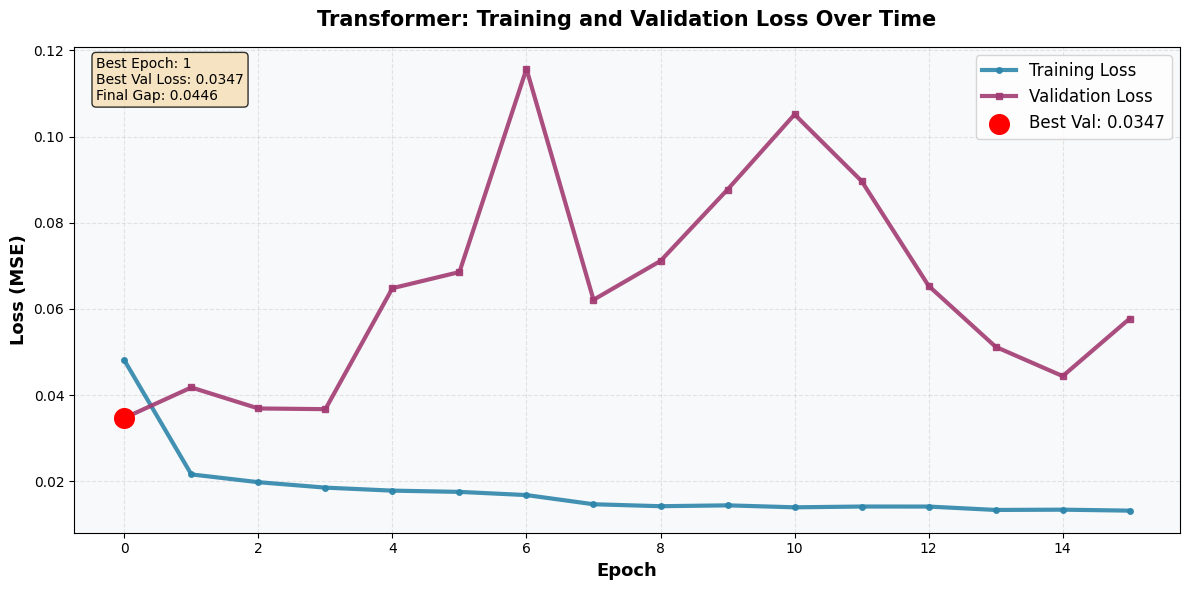


2. Detailed Training Analysis:


<Figure size 1200x600 with 0 Axes>

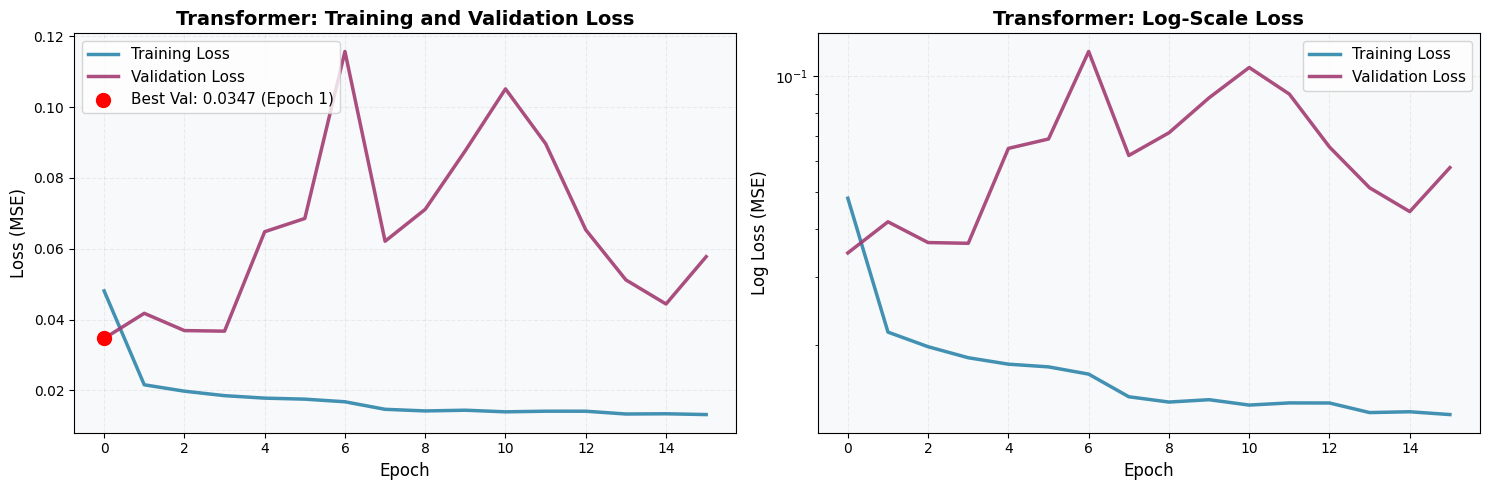


3. Learning Rate Schedule:


<Figure size 1200x500 with 0 Axes>

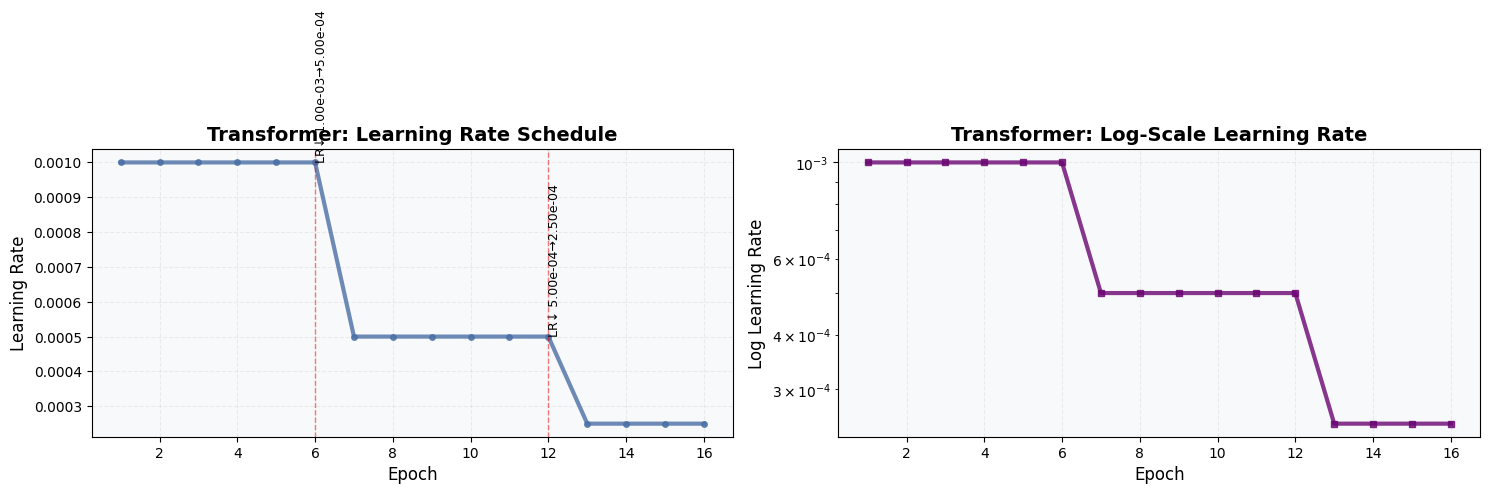


5. Comprehensive Training Summary:


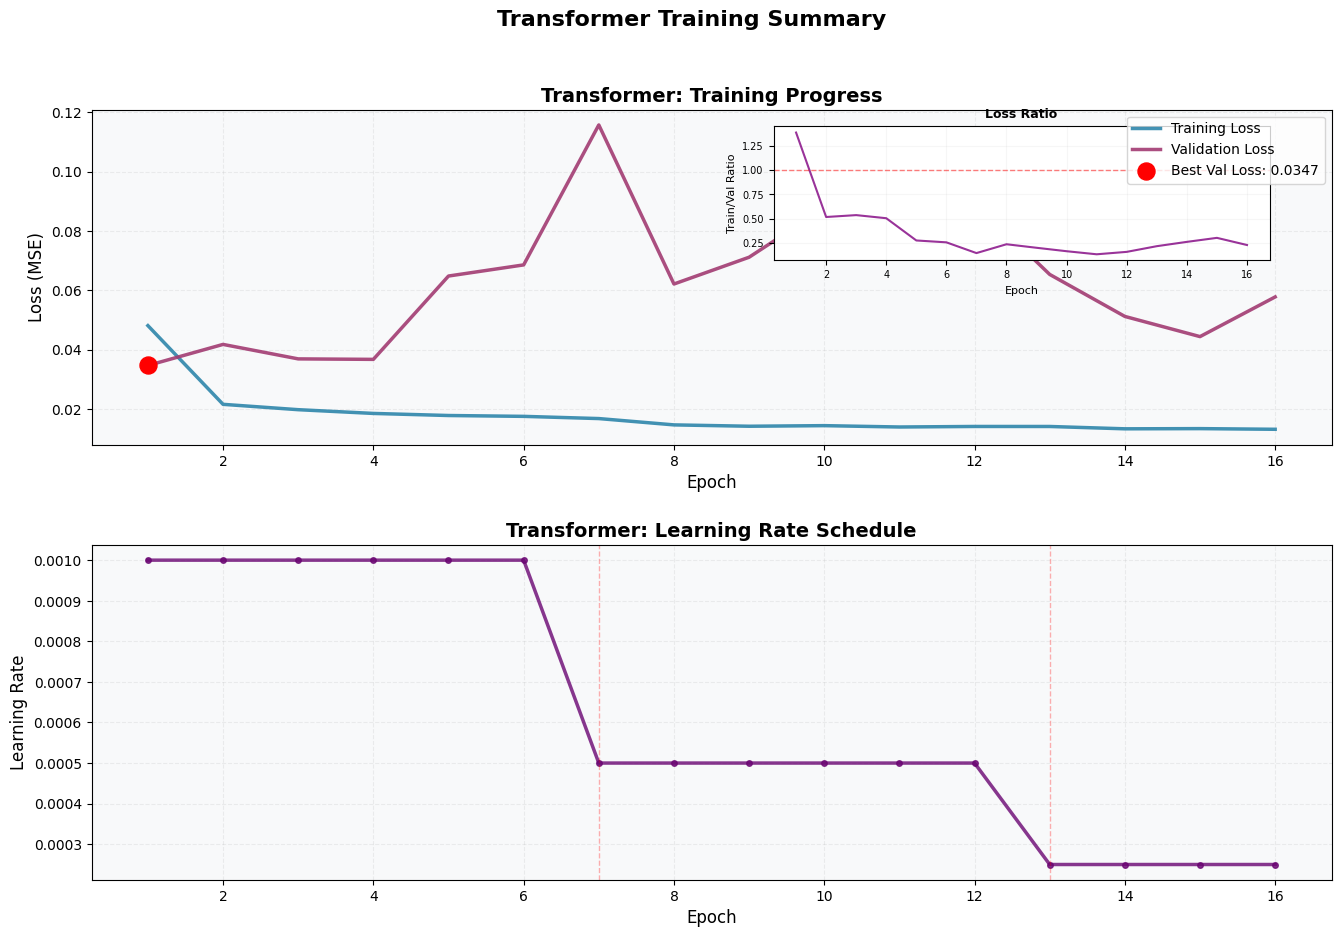

In [21]:
print("\n1. Simple Training Loss Plot:")
plot_simple_training_loss(train_losses, val_losses, model_name="Transformer")

print("\n2. Detailed Training Analysis:")
plot_transformer_training_loss(train_losses, val_losses, model_name="Transformer")

if 'learning_rates' in locals():
    print("\n3. Learning Rate Schedule:")
    plot_learning_rate_schedule(learning_rates, model_name="Transformer")

if 'grad_norms' in locals():
    print("\n4. Gradient Norm Analysis:")
    plot_gradient_norms(grad_norms, model_name="Transformer", grad_clip=1.0)

print("\n5. Comprehensive Training Summary:")
if 'grad_norms' in locals() and 'learning_rates' in locals():
    plot_transformer_training_summary(
        train_losses, val_losses, learning_rates, grad_norms, 
        model_name="Transformer"
    )
elif 'learning_rates' in locals():
    plot_transformer_training_summary(
        train_losses, val_losses, learning_rates, 
        model_name="Transformer"
    )
else:
    plot_transformer_training_summary(
        train_losses, val_losses, train_losses,  # Using train_losses as placeholder
        model_name="Transformer"
    )

In [22]:
def evaluate_on_validation(model, val_loader, scaler_y):
    """Evaluate the model on validation data"""
    
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            predictions.extend(outputs.numpy())
            actuals.extend(batch_y.numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)
    
    # Inverse transform to get original scale
    predictions = scaler_y.inverse_transform(predictions)
    actuals = scaler_y.inverse_transform(actuals)
    
    # Calculate metrics
    mse = np.mean((predictions - actuals) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))
    
    # Calculate R-squared
    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    print("\nValidation Set Evaluation:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")
    
    # Additional metrics
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")
    
    return predictions, actuals

# Evaluate on validation set
val_predictions, val_actuals = evaluate_on_validation(model, val_loader, scaler_y)


Validation Set Evaluation:
Mean Squared Error: 46.6603
Root Mean Squared Error: 6.8308
Mean Absolute Error: 4.7838
R-squared: 0.9689
Mean Absolute Percentage Error: 317746880.00%


In [23]:
def evaluate_model(model, test_loader, scaler_y):
    """Evaluate the model on test data"""
    
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            predictions.extend(outputs.numpy())
            actuals.extend(batch_y.numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)
    
    # Inverse transform to get original scale
    predictions = scaler_y.inverse_transform(predictions)
    actuals = scaler_y.inverse_transform(actuals)
    
    # Calculate metrics
    mse = np.mean((predictions - actuals) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))
    
    # Calculate R-squared
    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    print("\nTest Set Evaluation:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")
    
    # Additional metrics
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")
    
    return predictions, actuals

# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader, scaler_y)



Test Set Evaluation:
Mean Squared Error: 30.0003
Root Mean Squared Error: 5.4773
Mean Absolute Error: 4.2948
R-squared: 0.8026
Mean Absolute Percentage Error: 30.92%


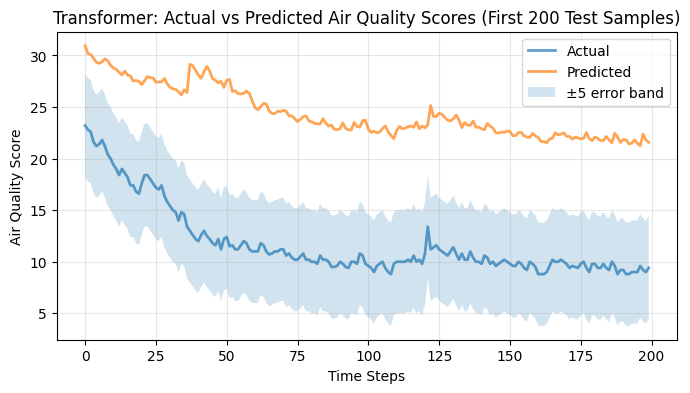

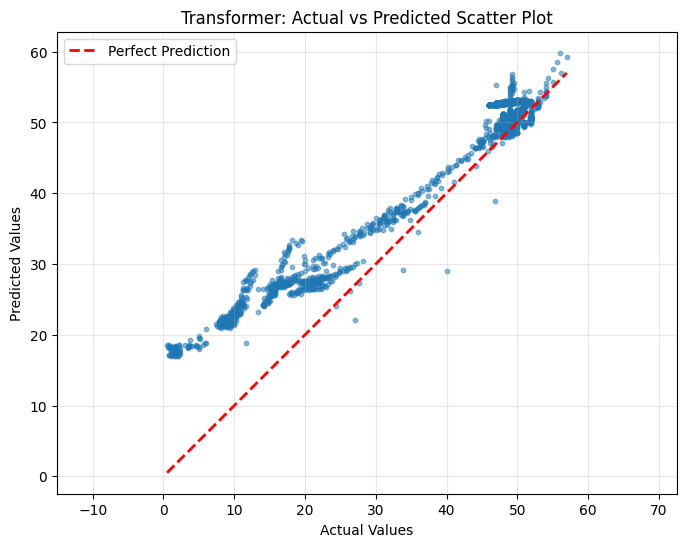

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(actuals[:200], label='Actual', alpha=0.7, linewidth=2)
plt.plot(predictions[:200], label='Predicted', alpha=0.7, linewidth=2)
plt.fill_between(range(min(200, len(actuals))), 
                 actuals[:200].flatten() - 5, 
                 actuals[:200].flatten() + 5, 
                 alpha=0.2, label='±5 error band')
plt.xlabel('Time Steps')
plt.ylabel('Air Quality Score')
plt.title('Transformer: Actual vs Predicted Air Quality Scores (First 200 Test Samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Additional plot: Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.5, s=10)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Transformer: Actual vs Predicted Scatter Plot')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

In [23]:
def predict_future_transformer(model, input_features, sequence_length=24, future_steps=12, feature_names=None):
    """
    Predict air quality score for future timestamps using Transformer
    """
    model.eval()
    
    # Set default feature names if not provided
    if feature_names is None:
        feature_names = feature_columns
    
    print("TRANSFORMER MODEL - INPUT SEQUENCE (Last 24 timestamps):")
    
    # Display the input sequence in a readable format
    input_features_reshaped = input_features.reshape(sequence_length, -1)
    
    # Create a DataFrame for better display
    input_df = pd.DataFrame(input_features_reshaped, columns=feature_names)
    
    # Add timestamp labels
    input_df.index = [f"T-{sequence_length - i}" for i in range(sequence_length)]
    input_df.index.name = "Timestamp"
    
    # Format display
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.float_format', lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else str(x))
    
    print(input_df.head(12).to_string())  # Show first 12 rows
    print("\n...")  # Indicate continuation
    print(input_df.tail(12).to_string())  # Show last 12 rows
    
    print(f"SEQUENCE SUMMARY:")
    
    # Display summary statistics
    print(f"Sequence shape: {input_features.shape}")
    print(f"Number of features: {len(feature_names)}")
    
    # Display range of values for each feature
    print("\nFeature ranges in input sequence:")
    for i, feature in enumerate(feature_names):
        col_data = input_features_reshaped[:, i]
        print(f"{feature:15s}: Min = {col_data.min():6.2f}, Max = {col_data.max():6.2f}, Mean = {col_data.mean():6.2f}")
    
    print("PREDICTION PROCESS:")
    
    # Make sure input is properly shaped
    if len(input_features.shape) == 2:
        input_features = input_features.reshape(1, sequence_length, -1)
    
    # Scale the input features
    print("Scaling input features...")
    input_scaled = scaler_X.transform(input_features.reshape(-1, input_features.shape[-1]))
    input_scaled = input_scaled.reshape(1, sequence_length, -1)
    
    predictions = []
    current_sequence = input_scaled.copy()
    
    print(f"\nPredicting {future_steps} future timestamps:")
    
    with torch.no_grad():
        for i in range(future_steps):
            # Convert to tensor
            input_tensor = torch.FloatTensor(current_sequence)
            
            # Make prediction using Transformer
            output = model(input_tensor)
            pred_scaled = output.numpy().flatten()[0]
            predictions.append(pred_scaled)
            
            # Display prediction progress
            print(f"Step {i+1:2d}: Scaled prediction = {pred_scaled:.4f}")
            
            # For next prediction, we need to update the sequence
            # This is simplified - in practice you might want a different strategy
            # for updating the sequence with predicted values
            new_sequence = np.roll(current_sequence, -1, axis=1)
            current_sequence = new_sequence
    
    # Inverse transform predictions
    predictions_array = np.array(predictions).reshape(-1, 1)
    predictions_original = scaler_y.inverse_transform(predictions_array)
    
    print("PREDICTION RESULTS:")
    
    # Display predictions
    print(f"\nPredicted air quality scores for next {future_steps} timestamps:")
    print(f"{'Timestamp':<15} {'Predicted Score':<20} {'Category':<25}")
    
    # Define score categories
    def get_category(score):
        if score <= 50:
            return "Excellent (0-50)"
        elif score <= 100:
            return "Good (51-100)"
        elif score <= 150:
            return "Moderate (101-150)"
        elif score <= 200:
            return "Unhealthy for Sensitive Groups (151-200)"
        else:
            return "Unhealthy (201+)"
    
    for i, pred in enumerate(predictions_original.flatten(), 1):
        category = get_category(pred)
        print(f"T+{i:<13} {pred:<20.2f} {category:<25}")
    
    # Display statistics
    print(f"Statistics:")
    print(f"Average predicted score: {predictions_original.mean():.2f}")
    print(f"Minimum predicted score: {predictions_original.min():.2f}")
    print(f"Maximum predicted score: {predictions_original.max():.2f}")
    print(f"Trend: {'Increasing' if predictions_original[-1] > predictions_original[0] else 'Decreasing' if predictions_original[-1] < predictions_original[0] else 'Stable'}")
    
    return predictions_original.flatten()


TRANSFORMER MODEL - DEMONSTRATION OF PREDICTION FUNCTION

Created synthetic sequence of shape: (24, 11)

CALLING PREDICT_FUTURE_TRANSFORMER FUNCTION
TRANSFORMER MODEL - INPUT SEQUENCE (Last 24 timestamps):
           temp  humid    co2  voc  pm25  pm10  hour   day  month    year  dayofweek
Timestamp                                                                           
T-24      30.73  42.32 514.71 0.16  8.90 12.32  8.00 15.00   3.00 2024.00       4.00
T-23      28.06  37.94 526.32 0.49 25.81 18.49  9.00 15.00   3.00 2024.00       4.00
T-22      24.73  30.72 465.08 0.27 12.28 34.47 10.00 15.00   3.00 2024.00       4.00
T-21      23.24  29.35 446.31 0.41  9.99 30.57 11.00 15.00   3.00 2024.00       4.00
T-20      20.19  31.08 494.06 0.13 28.72 48.63 12.00 15.00   3.00 2024.00       4.00
T-19      19.15  26.66 614.31 0.28  8.05 29.81 13.00 15.00   3.00 2024.00       4.00
T-18      19.64  30.27 456.26 0.22 18.00 31.87 14.00 15.00   3.00 2024.00       4.00
T-17      18.22  38.61 527.9

In [ ]:
def create_synthetic_sequence(sequence_length=24):
    """Create a synthetic sequence for testing the predict function with patterns"""
    np.random.seed(42)
    
    # Create base values with daily pattern
    base_hour = 8  # Start at 8 AM
    sequence = []
    
    for i in range(sequence_length):
        hour = (base_hour + i) % 24
        day_offset = (base_hour + i) // 24
        
        # Create realistic patterns
        # Temperature: cooler at night, warmer during day
        temp_base = 22 + 8 * np.sin(2 * np.pi * hour / 24)
        
        # Humidity: higher at night
        humid_base = 50 + 20 * np.cos(2 * np.pi * hour / 24)
        
        # CO2: higher during occupied hours
        co2_base = 400
        if 8 <= hour <= 20:  # Daytime occupancy
            co2_base += 200 * np.random.random()
        
        # Pollution: higher during day
        pollution_factor = 1.0 if 6 <= hour <= 22 else 0.5
        
        features = [
            temp_base + np.random.uniform(-2, 2),  # temp with noise
            humid_base + np.random.uniform(-5, 5),  # humid with noise
            co2_base + np.random.uniform(-50, 100),  # co2
            np.random.uniform(0.1, 0.5) * pollution_factor,  # voc
            np.random.uniform(5, 30) * pollution_factor,   # pm25
            np.random.uniform(10, 50) * pollution_factor,  # pm10
            hour,   # hour
            15 + day_offset,   # day
            3,   # month
            2024,                       # year
            (4 + day_offset) % 7     # dayofweek (starting Friday)
        ]
        sequence.append(features)
    
    return np.array(sequence)


# Example usage
print("TRANSFORMER MODEL - DEMONSTRATION OF PREDICTION FUNCTION")

# Create synthetic sequence
test_sequence = create_synthetic_sequence(sequence_length)
print(f"\nCreated synthetic sequence of shape: {test_sequence.shape}")

# Make predictions
print("CALLING PREDICT_FUTURE_TRANSFORMER FUNCTION")

future_predictions = predict_future_transformer(
    model, 
    test_sequence, 
    sequence_length=24, 
    future_steps=12,
    feature_names=feature_columns
)

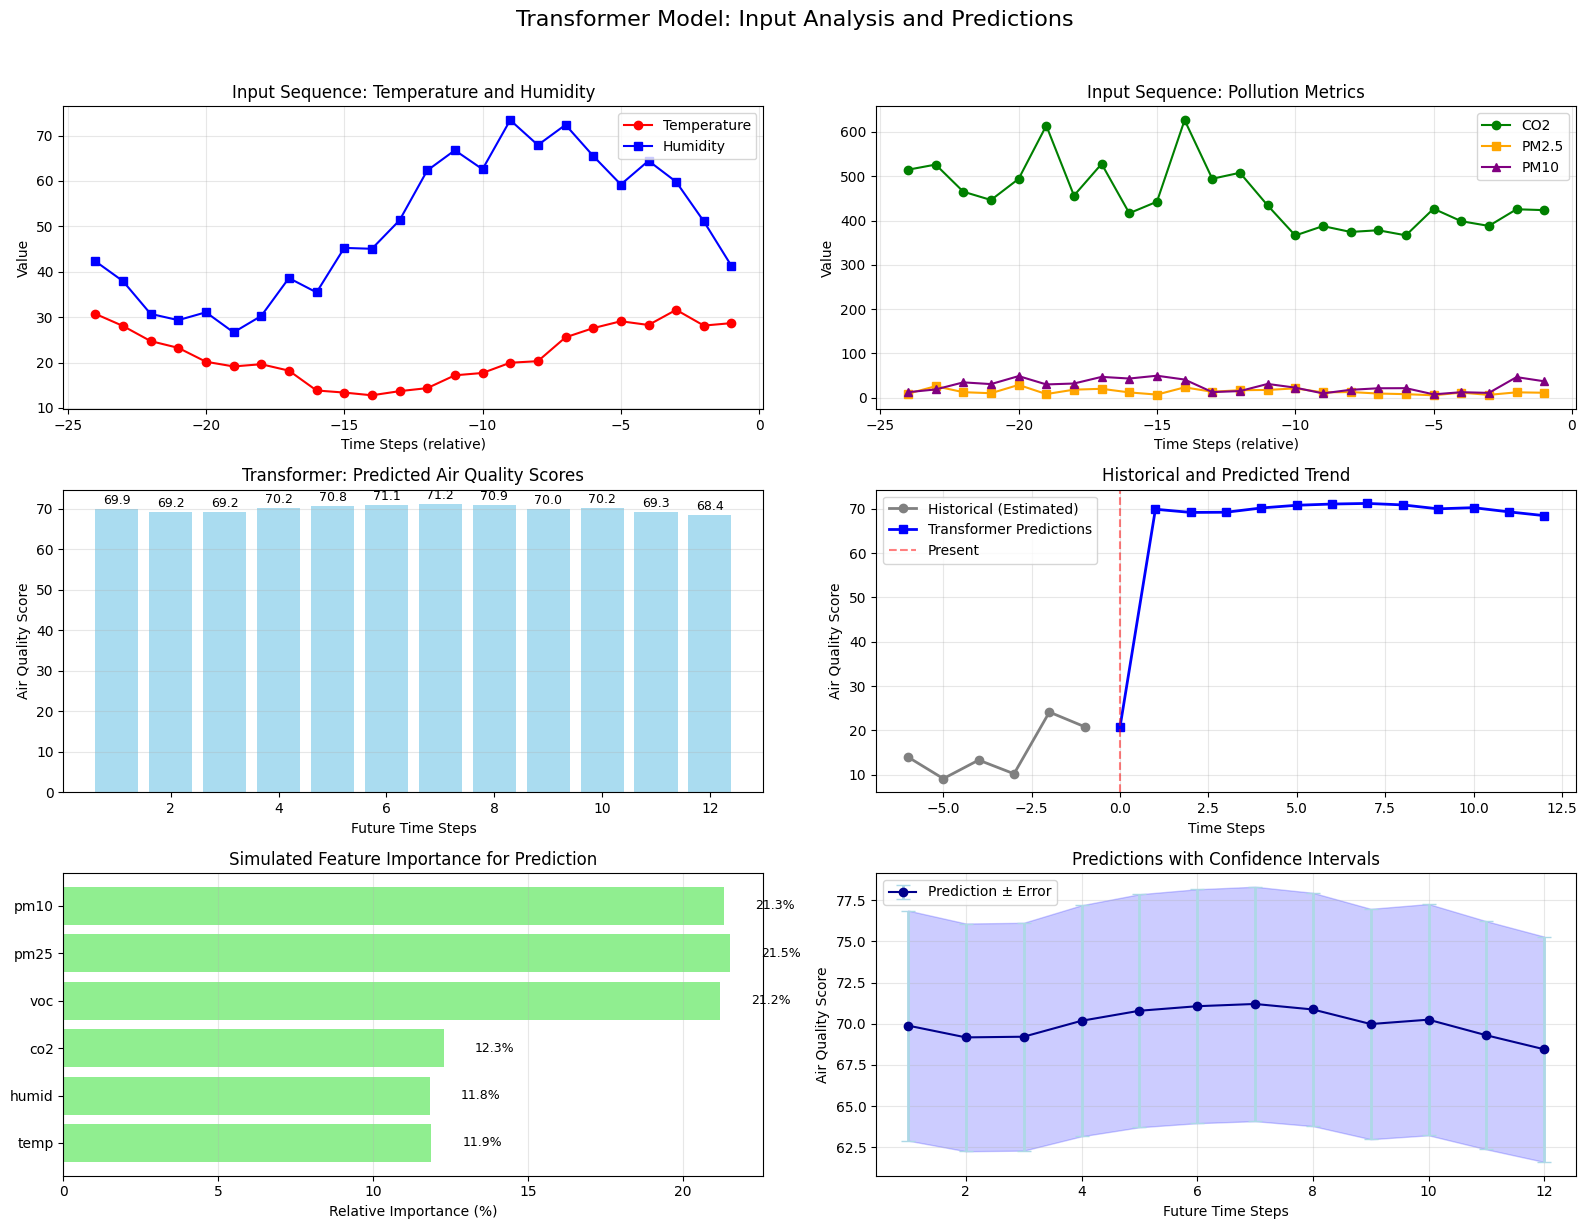

In [24]:
def visualize_transformer_predictions(input_sequence, predictions, feature_names):
    """Create visualization of input and predictions for Transformer"""
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))
    
    # Plot 1: Input sequence features
    ax1 = plt.subplot(3, 2, 1)
    time_steps = np.arange(-len(input_sequence), 0)
    
    # Plot environmental features
    ax1.plot(time_steps, input_sequence[:, 0], label='Temperature', marker='o', color='red')
    ax1.plot(time_steps, input_sequence[:, 1], label='Humidity', marker='s', color='blue')
    ax1.set_xlabel('Time Steps (relative)')
    ax1.set_ylabel('Value')
    ax1.set_title('Input Sequence: Temperature and Humidity')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Pollution features
    ax2 = plt.subplot(3, 2, 2)
    ax2.plot(time_steps, input_sequence[:, 2], label='CO2', marker='o', color='green')
    ax2.plot(time_steps, input_sequence[:, 4], label='PM2.5', marker='s', color='orange')
    ax2.plot(time_steps, input_sequence[:, 5], label='PM10', marker='^', color='purple')
    ax2.set_xlabel('Time Steps (relative)')
    ax2.set_ylabel('Value')
    ax2.set_title('Input Sequence: Pollution Metrics')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Predictions
    ax3 = plt.subplot(3, 2, 3)
    future_steps = np.arange(1, len(predictions) + 1)
    bars = ax3.bar(future_steps, predictions, color='skyblue', alpha=0.7)
    ax3.set_xlabel('Future Time Steps')
    ax3.set_ylabel('Air Quality Score')
    ax3.set_title(f'Transformer: Predicted Air Quality Scores')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, pred in zip(bars, predictions):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{pred:.1f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 4: Time series view
    ax4 = plt.subplot(3, 2, 4)
    combined_time = list(time_steps[-6:]) + [0] + list(future_steps)
    
    # Create synthetic "actual" values for the last few points (for visualization)
    last_actual_values = []
    for i in range(6):
        idx = len(input_sequence) - 6 + i
        # Calculate a simple score based on pollution (for visualization only)
        score = input_sequence[idx, 4] * 0.5 + input_sequence[idx, 5] * 0.3 + input_sequence[idx, 2] * 0.01
        last_actual_values.append(score)
    
    ax4.plot(combined_time[:6], last_actual_values, label='Historical (Estimated)', 
             marker='o', color='gray', linewidth=2)
    ax4.plot([0] + list(future_steps), [last_actual_values[-1]] + list(predictions), 
             label='Transformer Predictions', marker='s', color='blue', linewidth=2)
    ax4.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Present')
    ax4.set_xlabel('Time Steps')
    ax4.set_ylabel('Air Quality Score')
    ax4.set_title('Historical and Predicted Trend')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Feature importance (simulated)
    ax5 = plt.subplot(3, 2, 5)
    # Simulate feature importance (in practice, you'd calculate this differently)
    features = feature_names[:6]  # First 6 features
    importance = np.abs(np.random.randn(6))
    importance = importance / importance.sum() * 100
    
    bars = ax5.barh(features, importance, color='lightgreen')
    ax5.set_xlabel('Relative Importance (%)')
    ax5.set_title('Simulated Feature Importance for Prediction')
    ax5.grid(True, alpha=0.3, axis='x')
    
    # Add percentage labels
    for bar, imp in zip(bars, importance):
        width = bar.get_width()
        ax5.text(width + 1, bar.get_y() + bar.get_height()/2., 
                f'{imp:.1f}%', va='center', fontsize=9)
    
    # Plot 6: Prediction confidence intervals
    ax6 = plt.subplot(3, 2, 6)
    
    # Create confidence intervals (simulated)
    pred_errors = predictions * 0.1  # 10% error
    
    ax6.errorbar(future_steps, predictions, yerr=pred_errors, 
                fmt='o-', color='darkblue', ecolor='lightblue', 
                elinewidth=2, capsize=5, label='Prediction ± Error')
    ax6.fill_between(future_steps, predictions - pred_errors, 
                    predictions + pred_errors, alpha=0.2, color='blue')
    ax6.set_xlabel('Future Time Steps')
    ax6.set_ylabel('Air Quality Score')
    ax6.set_title('Predictions with Confidence Intervals')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.suptitle('Transformer Model: Input Analysis and Predictions', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Visualize the results
visualize_transformer_predictions(test_sequence, future_predictions, feature_columns)


In [ ]:
def save_model(model, scaler_X, scaler_y, feature_columns, sequence_length):
    """Save the trained model and preprocessing objects"""
    
    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_config': {
            'input_size': len(feature_columns),
            'd_model': d_model,
            'nhead': nhead,
            'num_encoder_layers': num_encoder_layers,
            'dim_feedforward': dim_feedforward,
            'dropout': dropout,
            'max_len': sequence_length
        },
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'feature_columns': feature_columns,
        'sequence_length': sequence_length,
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    torch.save(save_dict, 'transformer_air_quality_model.pth')
    print("Model saved as 'transformer_air_quality_model.pth'")

# Save the model
save_model(model, scaler_X, scaler_y, feature_columns, sequence_length)

print("TRANSFORMER MODEL TRAINING AND PREDICTION COMPLETED")